In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to your data directory
data_directory = '/content/drive/My Drive/data'
# Function to calculate SDNN from heart rate data
def calculate_sdnn(heart_rate_values, window_size=5):
    # Convert heart rate to RR intervals (assuming constant heart rate for simplicity)
    rr_intervals = 60 / heart_rate_values  # since values are in bpm

    # Calculate SDNN over a moving window
    sdnn_values = []
    for i in range(len(rr_intervals) - window_size + 1):
        sdnn_values.append(np.std(rr_intervals[i:i+window_size]))

    return np.array(sdnn_values)

# Modified function to load and preprocess heart rate data
def load_and_preprocess_heartrate(subject_id):
    file_path = os.path.join(data_directory, 'heart_rate', f'{subject_id}_heartrate.txt')
    data = pd.read_csv(file_path, header=None, names=['date', 'heartrate'])
    heartrate_values = data['heartrate']

    # Calculate SDNN from heart rate data
    sdnn_values = calculate_sdnn(heartrate_values)

    return sdnn_values

def load_labeled_sleep(subject_id):
    file_path = os.path.join(data_directory, 'labels', f'{subject_id}_labeled_sleep.txt')
    data = pd.read_csv(file_path, header=None, delim_whitespace=True, names=['date', 'stage'])
    # Encode sleep labels as binary values: 1 for awake (label=0), 0 for asleep (labels 1-5)
    return (data['stage'] == 0).astype(int).values

subject_ids = [file.split('_')[0] for file in os.listdir(os.path.join(data_directory, 'labels')) if '_labeled_sleep.txt' in file]

X_heartrate = []
y_sleep = []

sequence_length = 50

for subject_id in subject_ids:
    heartrate_values = load_and_preprocess_heartrate(subject_id)
    sleep_labels = load_labeled_sleep(subject_id)

    for i in range(0, len(heartrate_values) - sequence_length):
        X_heartrate.append(heartrate_values[i:i+sequence_length])
        y_sleep.append(sleep_labels[min(i+sequence_length-1, len(sleep_labels)-1)])

In [ ]:
X_heartrate = np.array(X_heartrate)
y_sleep = np.array(y_sleep)

label_encoder = LabelEncoder()
y_sleep = label_encoder.fit_transform(y_sleep)

scaler = StandardScaler()
X_heartrate_scaled = scaler.fit_transform(X_heartrate)

X_train, X_test, y_train, y_test = train_test_split(
    X_heartrate_scaled, y_sleep, test_size=0.1, random_state=42
)


In [ ]:
# Model architecture
num_classes = 1  # Binary classification: awake or asleep
model = Sequential([
    LSTM(units=100, input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(units=50, return_sequences=True),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
# Model training
history = model.fit(
    X_train[..., np.newaxis],  # Expand dimension for LSTM input shape
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Model evaluation
y_pred = model.predict(X_test[..., np.newaxis])
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes
accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)


Epoch 1/20
6398/6398 [==============================] - 427s 66ms/step - loss: 0.5457 - accuracy: 0.7642 - val_loss: 0.5439 - val_accuracy: 0.7620
Epoch 2/20
6398/6398 [==============================] - 421s 66ms/step - loss: 0.5396 - accuracy: 0.7656 - val_loss: 0.5332 - val_accuracy: 0.7680
Epoch 3/20
6398/6398 [==============================] - 425s 66ms/step - loss: 0.5175 - accuracy: 0.7766 - val_loss: 0.5038 - val_accuracy: 0.7829
Epoch 4/20
6398/6398 [==============================] - 427s 67ms/step - loss: 0.4690 - accuracy: 0.7995 - val_loss: 0.4353 - val_accuracy: 0.8131
Epoch 5/20
6398/6398 [==============================] - 423s 66ms/step - loss: 0.3941 - accuracy: 0.8341 - val_loss: 0.3580 - val_accuracy: 0.8509
Epoch 6/20
6398/6398 [==============================] - 417s 65ms/step - loss: 0.3210 - accuracy: 0.8683 - val_loss: 0.2995 - val_accuracy: 0.8756
Epoch 7/20
6398/6398 [==============================] - 423s 66ms/step - loss: 0.2570 - accuracy: 0.8949 - val_loss: 0

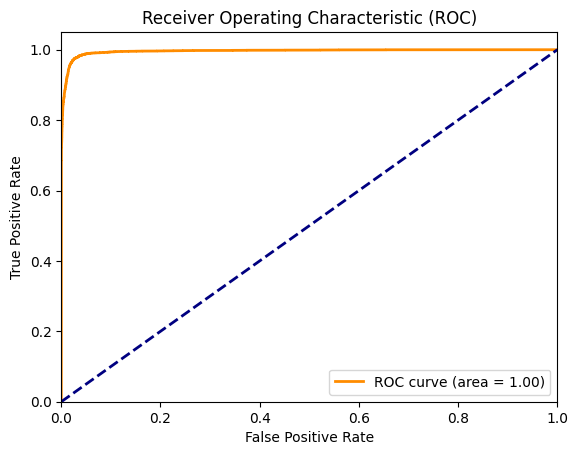

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
